# More Regularization

In an attempt to understand regularization in action, and the norm & cost function loss plots.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='white')

In [30]:
from sklearn.preprocessing import PolynomialFeatures

In [31]:
np.random.seed(42)

m, n = 100, 1
X = np.linspace(0, 1, 100).reshape(-1, 1)

pf = PolynomialFeatures(degree=100) # we will include the bias term
X_poly = pf.fit_transform(X)

# the target is polynomial function with degree=2
y = 3 * X**2 + .5 * X + 4 + (np.random.randn(m, 1) * 0.6)

## The Normal Equation

With the normal equation, we can find the best $\theta$ for any degree.

$\hat{\theta}=(X^{T} X)^{-1} X^T y$

In [32]:
def normal_equation(X_b, y):
    return np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y


The cost function for **Ridge Regression** is as follows:

$J(\theta)=MSE(\theta)+\alpha\frac{1}{2}\sum_{i=1}^n \theta_i^2$

The closed form equation:

$\hat{\theta} = (X^T X + \alpha A)^{-1}X^Ty$, where $A$ is the $(n+1)\times(n+1)$ identity matrix.

In [33]:
def ridge_normal(X_b, y, alpha=0.5):
    A = np.identity(X_b.shape[1])
    A[0][0] = 0
    return np.linalg.pinv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

The cost function for **Lasso Regression** is as follows:

$J(\theta)=MSE(\theta)+\alpha\sum_{i=1}^n |\theta_i|$

It doesn't have a closed form (but can be reformulated as a convex optimization problem to have a solution even without a closed form - see [this](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.cs.cmu.edu/~psarkar/sds383c_16/lecture10_scribe.pdf)). 

For now, we will simply attempt with a batch gradient descent (cuz the math is so much ;-;).

The cost function for **Elastic Net** is as follows:

$J(\theta) = MSE(\theta) + r\alpha \sum_{i=1}^{n} |\theta_i| + \frac{1-r}{2}\alpha\sum_{i=1}^{n}\theta_{i}^{2}$

In [34]:
def mean_squared_error(
    theta, X_b, y
):
    return np.mean((X_b @ theta - y)**2)

Finally, the batch gradient descent algorithm

In [35]:
def batch_gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    eta=0.1,
    n_iterations=1000,
    theta_start=None,
    tol=.001,
    r=0, # ridge by default
    alpha=0 # no regularization by default
    ):
    
    m, n = X_b.shape
    if theta_start is None:
        theta = np.random.randn(n, 1)
    else:
        theta = theta_start.copy()
    cost_function = {
        0: (theta, mean_squared_error(theta, X_b, y))
    }
    
    for iteration in range(n_iterations):

        # apply elastic net
        reg_term = (r*alpha*np.abs(theta)) + ((1-r)/2)*alpha*(theta**2)
        reg_term[0][0] = 0
        gradients = 2/m * X_b.T @ (X_b @ theta - y) + reg_term
        
        theta = theta - eta * gradients

        # append results
        score = mean_squared_error(theta, X_b, y)
        cost_function[iteration+1] = (theta, score, np.sum(reg_term))

        if (np.abs(score - cost_function[iteration][1]) < tol):
            break


    return theta, cost_function

## A Bunch'a Plots

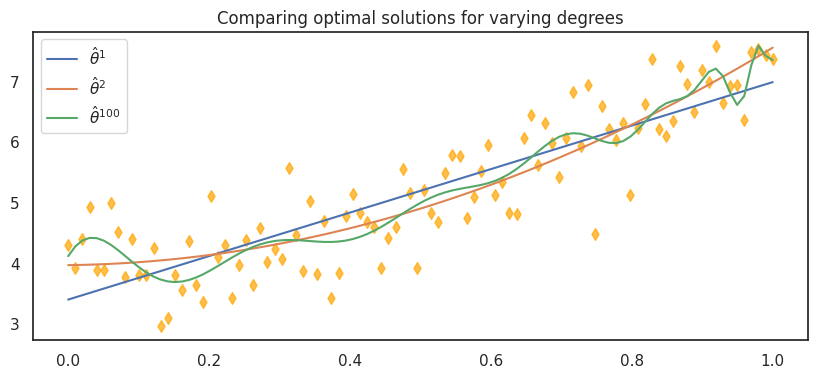

In [36]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.scatter(X, y, marker="d", color="orange", alpha=0.7)

theta_best1 = normal_equation(X_poly[:,:2], y)
theta_best2 = normal_equation(X_poly[:,:3], y)
theta_best100 = normal_equation(X_poly, y)

ax.plot(X, X_poly[:, :2] @ theta_best1, label="$\\hat{\\theta}^1$")
ax.plot(X, X_poly[:, :3] @ theta_best2, label="$\\hat{\\theta}^2$")
ax.plot(X, X_poly @ theta_best100, label="$\\hat{\\theta}^{{100}}$")
plt.title("Comparing optimal solutions for varying degrees")
plt.legend()
plt.show()

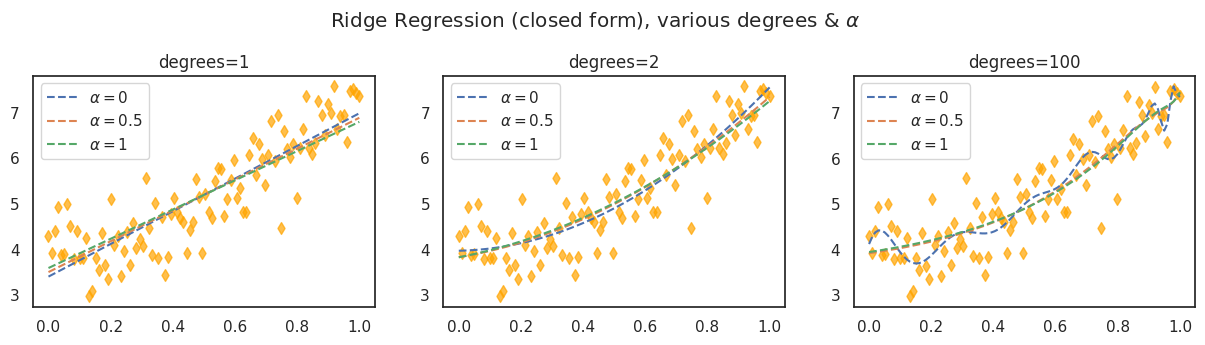

In [37]:
degrees = [1, 2, 100]

_, ax = plt.subplots(1, len(degrees), figsize=(15, 3))

for j, degree in enumerate(degrees):
    ax[j].scatter(X, y, marker="d", color="orange", alpha=0.7)
    ax[j].set_title(f"degrees={degree}")

    for alpha in [0, .5, 1]:
        theta_best = ridge_normal(X_poly[:, :degree+1], y, alpha=alpha)
        ax[j].plot(
            X, X_poly[:, :degree+1] @ theta_best, 
            label=f"$\\alpha={{{alpha}}}$", ls="dashed"
            ) 

    ax[j].legend()

plt.suptitle("Ridge Regression (closed form), various degrees & $\\alpha$", y=1.1)
plt.show()

/tmp/ipykernel_3369086/4241729428.py:4: RuntimeWarning: overflow encountered in square
  return np.mean((X_b @ theta - y)**2)
/tmp/ipykernel_3369086/287905262.py:24: RuntimeWarning: overflow encountered in square
  reg_term = r*alpha*np.abs(theta) + ((1-r)/2)*alpha*(theta**2)
/tmp/ipykernel_3369086/4241729428.py:4: RuntimeWarning: invalid value encountered in matmul
  return np.mean((X_b @ theta - y)**2)
/tmp/ipykernel_3369086/287905262.py:26: RuntimeWarning: invalid value encountered in matmul
  gradients = 2/m * X_b.T @ (X_b @ theta - y) + reg_term


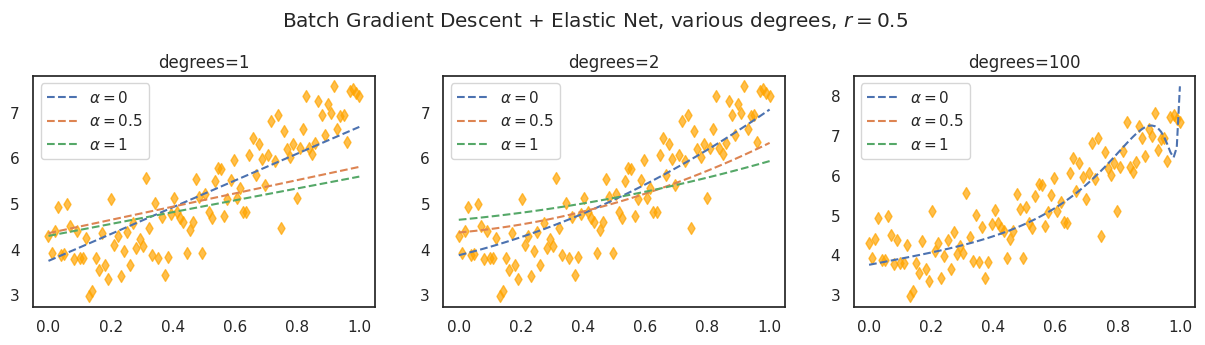

In [38]:
degrees = [1, 2, 100]
r = .5

_, ax = plt.subplots(1, len(degrees), figsize=(15, 3))

for j, degree in enumerate(degrees):
    ax[j].scatter(X, y, marker="d", color="orange", alpha=0.7)
    ax[j].set_title(f"degrees={degree}")

    for alpha in [0, .5, 1]:
        theta_best, _ = batch_gradient_descent(X_poly[:, :degree+1], y, r=r, alpha=alpha)
        ax[j].plot(
            X, X_poly[:, :degree+1] @ theta_best, 
            label=f"$\\alpha={{{alpha}}}$", ls="dashed"
            ) 

    ax[j].legend()

plt.suptitle(f"Batch Gradient Descent + Elastic Net, various degrees, $r={r}$", y=1.1)
plt.show()